# EMC Final Project

In [2]:
import matplotlib.pyplot as plt
from brian2 import *

%matplotlib inline

First let's describe the dynamics of the saturating synapse model (since it's simpler):

$$
\begin{eqnarray}
s_n(t)       &=& \sum_{t_n} \delta ( t - t_n) \\
\dot{r_n}(t) &=& -\lambda_s r_n(t) + s_n(t) \\
\dot{V_n}(t) &=& -\lambda_V V_n(t) + \sum_{m=1}^T A_{nm} \tanh{(\gamma r_m(t))} + V_r \lambda_s r_n(t) - \theta s_n(t) + I_{e,n}(t) \\
\end{eqnarray}
$$

Next, let's describe each of the various parameters and variables necessary to implement the model:

* Incoming spiketrain, $s(t)$
    * Just a train of delta impulses - no parameters needed.
    * Simply increment on-spike with Brian2
* Normalized synaptic current, $r(t)$
    * $\lambda_s = \tau_s^{-1}$ : time constant of synaptic decay (consistent for all synapses in this model)
* Membrane potential, $V(t)$
    * $\lambda_V = \tau_m^{-1}$ : membrane time constant for neuron
    * $A_{nm}$  : maximum synapse strength from neuron `m` to neuron `n`
    * $\gamma$  : "fraction of synaptic resources consumed" by the synapse
    * $V_r$     : resting voltage (temporally integrated size of afterdepolarization recovery current)
    * $\theta$  : threshold voltage (compared to reset voltage)
    * $I_{e,n}$ : external input current
    
Now, let's set some of those parameters as defined in the paper and supplemental materials.

In [3]:
lambda_s = 100 * ms
lambda_v = 1 * second

theta = 0.05
gamma = theta
V_r = 0.9 * theta

Now, we'll define the differential equations for Brian2 to implement in the model.

In [4]:
eqsNeuSat = '''
dV/dt = -lambda_v * V + satsyn + V_r * lambda_s * r  + Iext : 1
satsyn : 1 # saturation synapse summation term

dr/dt = -lambda_s * r : 1
'''
resetSat = 'V -= theta'
threshSat = 'V > theta'
eqsSynSat = '''
A : 1 # maximum synaptic weight
satsyn_post = A * tanh(gamma * r_pre) : 1 (summed)
'''
eqsPreSat = 'r += 1'

In [5]:
N = 50
g = 0.5
p = 0.1

A = np.zeros(N**2)
inds = permutation(N**2)
A[inds[0:int(p*N**2)]] = g**2/(N*p) * randn(int(p*N**2))

In [6]:
start_scope()

check_neur = NeuronGroup(N, eqsNeuSat, threshold=threshSat, reset=resetSat, method='rk4')
check_neur.V = V_r

check_syn = Synapses(check_neur, check_neur, eqsSynSat, on_pre=eqsPreSat)
check_syn.connect(p=p)
check_syn.A = g**2/(N*p) * randn(check_syn.N[:])

WARNING    /opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/jovyan/.cache/cython/brian_extensions/_cython_magic_264a06b9056d01074f353565692c89b3.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]


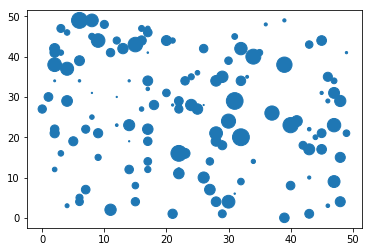

In [9]:
scatter(check_syn.i,check_syn.j,s=check_syn.A*2000)